## Setup

In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [77]:
import matplotlib
import numpy as np
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import matplotlib.pyplot as plt
import pandas as pd
import joblib
from pathlib import Path
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Masking, BatchNormalization
from tensorflow.keras.metrics import RootMeanSquaredError, CosineSimilarity

from src.constants import PROCESSED_POLCOM_DATA_2022_M_PATH, PROCESSED_POLCOM_DATA_2022_Y_PATH, PROCESSED_AZURE_DATA_PATH
from src.metrics import balanced_sla_loss

In [78]:
def load_dfs(path):
    path = Path(path)
    scaler = joblib.load(f"{path}/scaler.pkl")
    dfs = {
        file.stem: pd.read_parquet(file)
        for file in path.glob("*.parquet")
    }
    return dfs, scaler

In [79]:
def train_on_dfs():
    NUMBER_OF_DAILY_TIME_STEPS = 12
    def create_multi_feature_sequences(data, seq_length=NUMBER_OF_DAILY_TIME_STEPS, forecast_horizon=NUMBER_OF_DAILY_TIME_STEPS):
        """Convert multi-feature time series into sequences for multi-step forecasting."""
        X, y = [], []
        for i in range(len(data) - seq_length - forecast_horizon + 1):
            X.append(data.iloc[i:i+seq_length].values)  # Multi-feature input
            y.append(data.iloc[i+seq_length:i+seq_length+forecast_horizon].values)  # Predict all features
        return np.array(X), np.array(y)
    
    SEQ_LENGTH = NUMBER_OF_DAILY_TIME_STEPS * 7
    FORECAST_HORIZON = NUMBER_OF_DAILY_TIME_STEPS * 7
    
    X_train_list, y_train_list = [], []
    
    for vm, df in dfs_M.items():  # Use the dataset after trimming
        df_scaled = pd.DataFrame(df, index=df.index, columns=df.columns)  # Preserve column names
    
        X, y = create_multi_feature_sequences(df, SEQ_LENGTH, FORECAST_HORIZON)
    
        X_train_list.append(X)
        y_train_list.append(y)
    
    # Combine all sequences into a single training dataset
    X_train = np.vstack(X_train_list)
    y_train = np.vstack(y_train_list)
    
    print("Final Training Shape:", X_train.shape, y_train.shape)
    
    # Define model function
    def build_cnn_lstm_model(num_features=NUM_FEATURES):
        """Builds a CNN-LSTM model with optional inputs (handles missing features)."""
    
        # Input Layer (Optional: Can have missing values handled by Masking)
        inputs = Input(shape=(SEQ_LENGTH, num_features))
        
        # Masking Layer (ignores missing values)
        masked_inputs = Masking(mask_value=0.0)(inputs)  # Assuming missing values are represented as 0
    
        # 1D Convolution Layer
        conv = Conv1D(filters=128, kernel_size=NUMBER_OF_DAILY_TIME_STEPS, activation="relu", padding="same")(masked_inputs)
        
        conv = BatchNormalization()(conv)
    
        # LSTM Layer
        lstm = LSTM(128, return_sequences=False)(conv)
    
        # Fully Connected Layer
        dense = Dense(256, activation="relu")(lstm)
    
        # Output Layer (FORECAST_HORIZON x NUM_FEATURES)
        outputs = Dense(FORECAST_HORIZON * num_features, activation="linear")(dense)
    
        # Reshape output to match (batch, forecast_horizon, num_features)
        outputs = tf.keras.layers.Reshape((FORECAST_HORIZON, num_features))(outputs)
    
        # Define and compile model
        model = Model(inputs, outputs)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(
        optimizer=optimizer,
        loss=lambda y_true, y_pred: balanced_sla_loss(
            y_true, y_pred,
            tolerance=0.1,
            under_scale=10.0,
            over_scale=1.0
        ),
        metrics=[RootMeanSquaredError(name="RMSE"), CosineSimilarity(name="CS")]
    )
    
        return model
    
    # Build model
    model = build_cnn_lstm_model()
    
    # Print model summary
    model.summary()
    
    # Replace NaN values with zero (if using Masking layer)
    X_train = np.nan_to_num(X_train, nan=0.0)
    y_train = np.nan_to_num(y_train, nan=0.0)
    
    np.count_nonzero(X_train == 0), np.count_nonzero(y_train == 0)
    
    np.count_nonzero(X_train != 0), np.count_nonzero(y_train != 0)
    
    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
    
    return model, X_train, y_train


In [80]:
def test_on_dfs(model):
    # Select a random sample from X_train
    sample_idx = 322
    sample_input = X_train[sample_idx:sample_idx+1]  # Pick one example
    actual_output = y_train[sample_idx]  # Corresponding true values
    
    # Make predictions
    predicted_output = model.predict(sample_input)
    
    # Reshape for visualization
    actual_output = actual_output.reshape(FORECAST_HORIZON, NUM_FEATURES)
    predicted_output = predicted_output.reshape(FORECAST_HORIZON, NUM_FEATURES)
    
    # Plot each feature separately
    fig, axes = plt.subplots(NUM_FEATURES, 1, figsize=(10, 5 * NUM_FEATURES))
    
    feature_names = ["CPU", "MEMORY", "DISK", "NETWORK"]
    
    for i in range(NUM_FEATURES):
        ax = axes[i] if NUM_FEATURES > 1 else axes
        ax.plot(actual_output[:, i], label="Actual", marker="o")
        ax.plot(predicted_output[:, i], label="Predicted", marker="x")
        ax.set_xlabel("Time Steps Ahead")
        ax.set_ylabel(f"{feature_names[i]} Usage")
        ax.set_title(f"Predicted vs. Actual - {feature_names[i]}")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

Final Training Shape: (1338, 84, 4) (1338, 84, 4)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 84, 4)]           0         
                                                                 
 masking_4 (Masking)         (None, 84, 4)             0         
                                                                 
 conv1d_4 (Conv1D)           (None, 84, 128)           6272      
                                                                 
 batch_normalization_4 (Batc  (None, 84, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
         

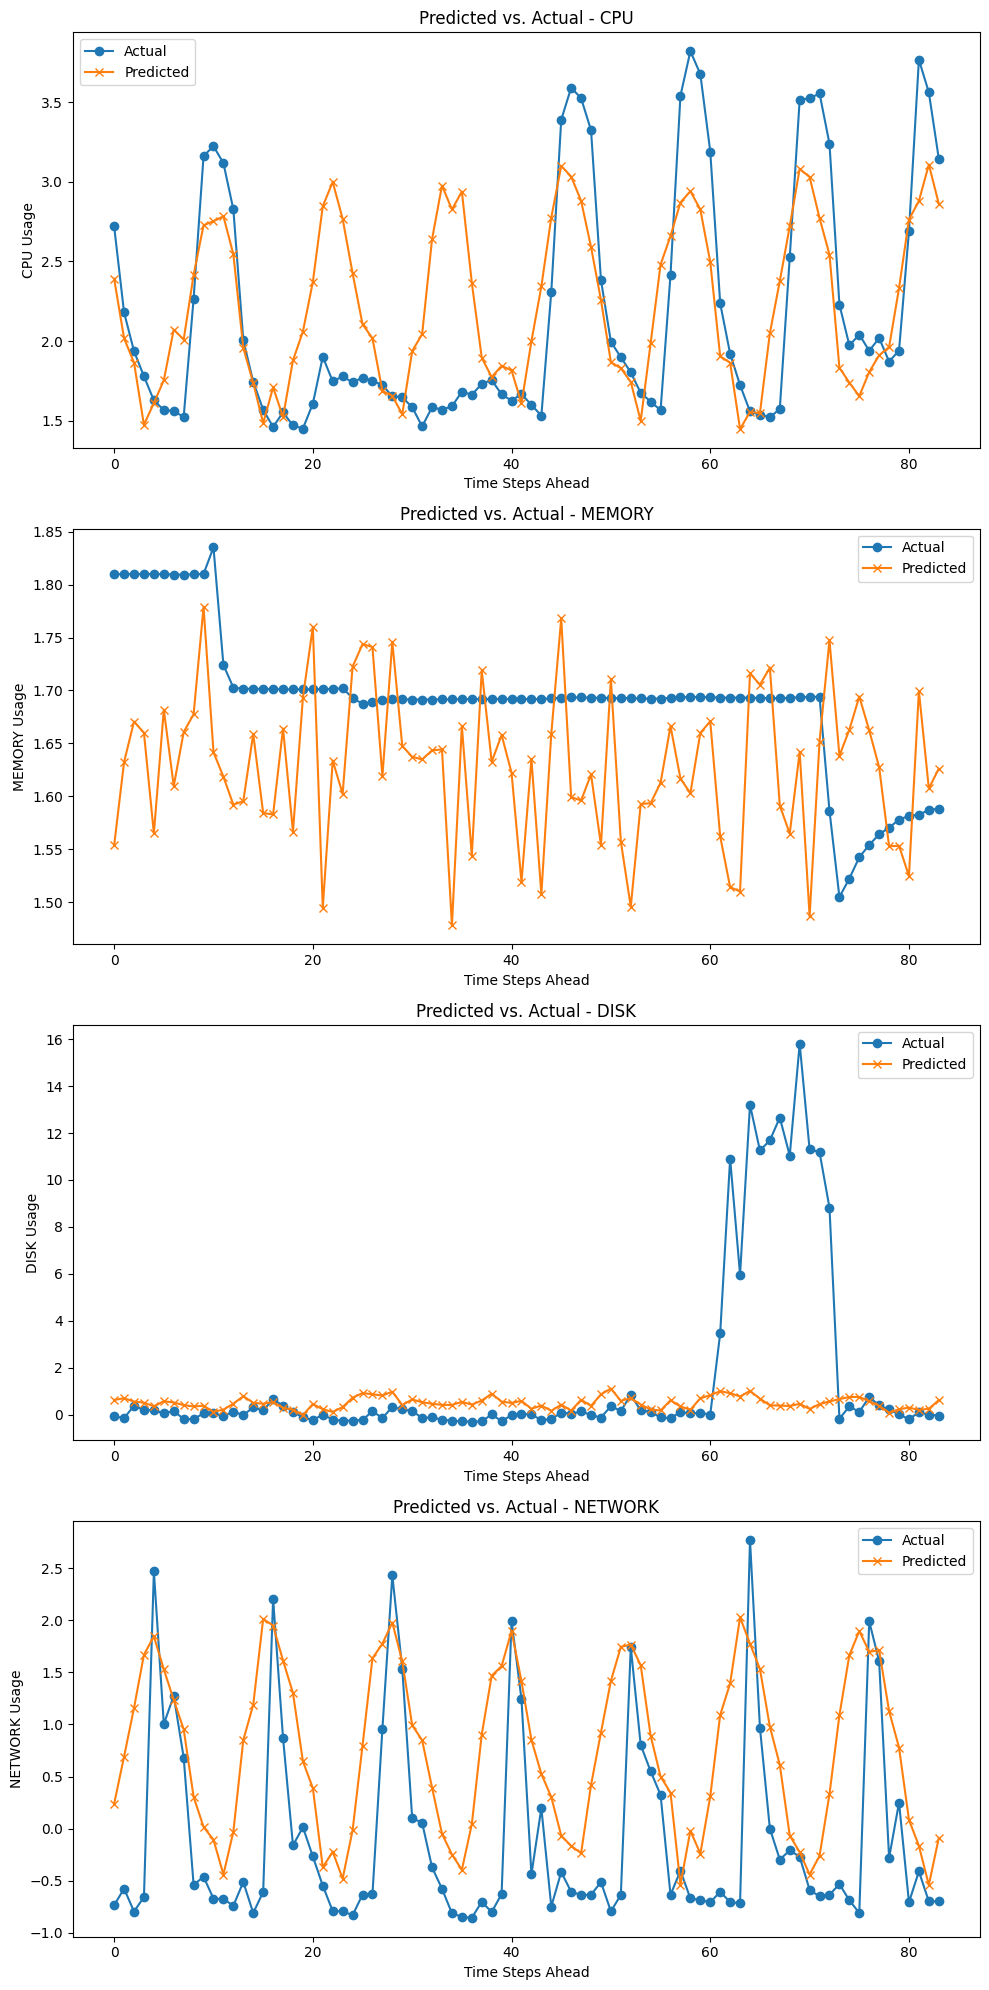

In [82]:
NUM_FEATURES = 4
dfs_M, scaler = load_dfs("../data/processed/standardized_trimmed_M")
model, X_train, y_train = train_on_dfs()
test_on_dfs(model)

Final Training Shape: (1338, 84, 3) (1338, 84, 3)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 84, 3)]           0         
                                                                 
 masking_5 (Masking)         (None, 84, 3)             0         
                                                                 
 conv1d_5 (Conv1D)           (None, 84, 128)           4736      
                                                                 
 batch_normalization_5 (Batc  (None, 84, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
         

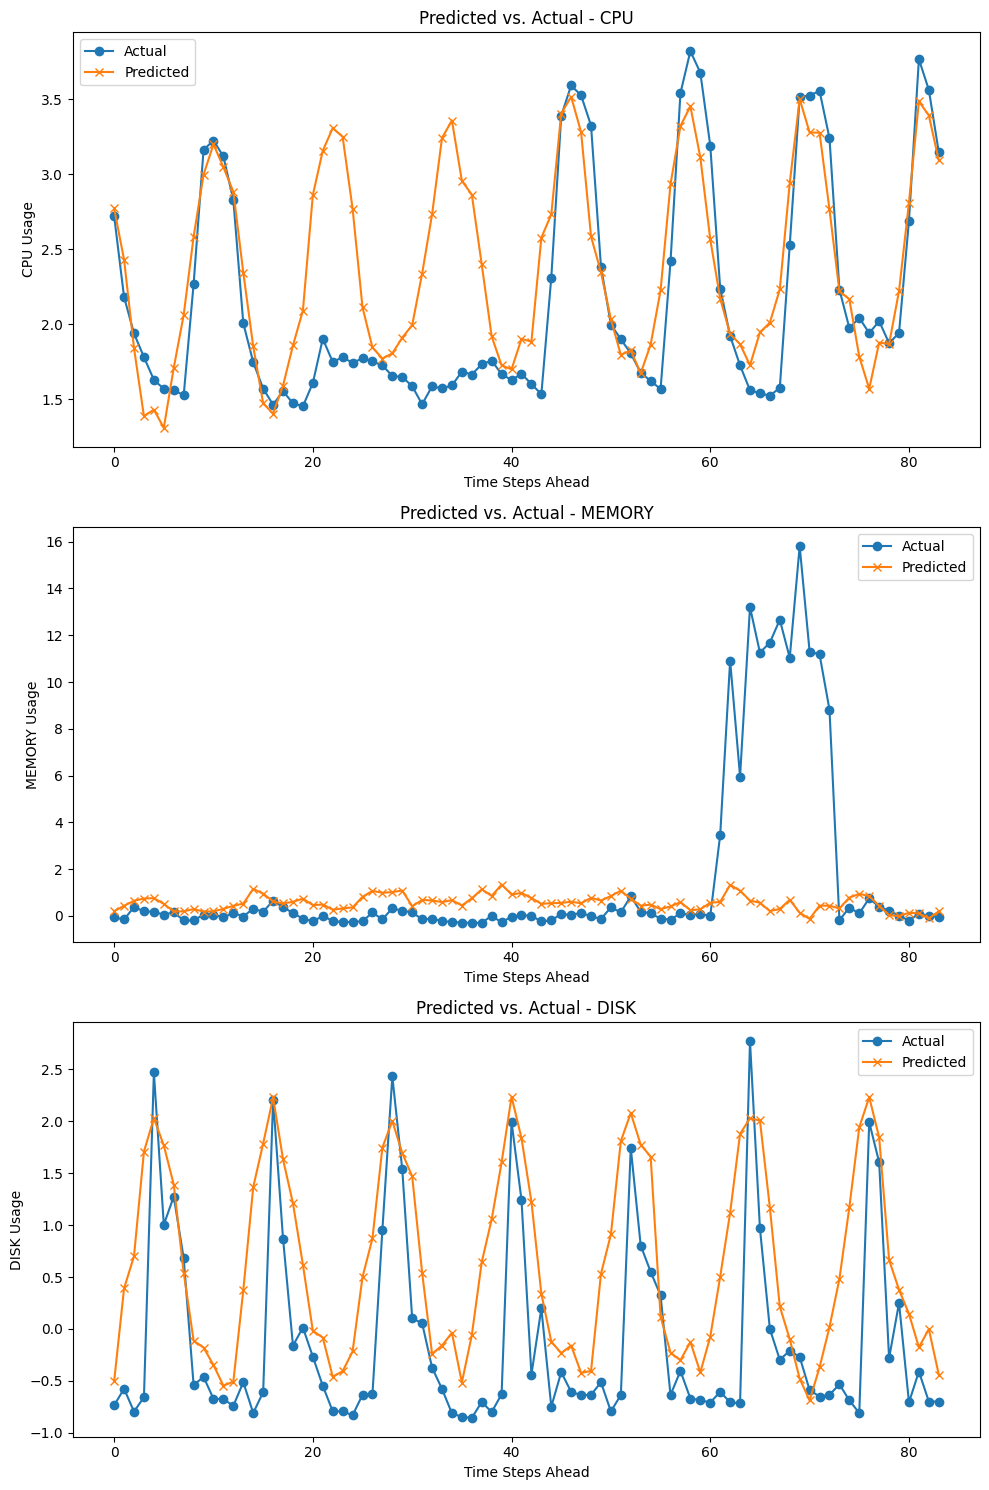

In [83]:
NUM_FEATURES = 3
dfs_M, scaler = load_dfs("../data/processed/cpu_disk_network_features_standardized_M")
model, X_train, y_train = train_on_dfs()
test_on_dfs(model)

Final Training Shape: (1338, 84, 1) (1338, 84, 1)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 84, 1)]           0         
                                                                 
 masking_6 (Masking)         (None, 84, 1)             0         
                                                                 
 conv1d_6 (Conv1D)           (None, 84, 128)           1664      
                                                                 
 batch_normalization_6 (Batc  (None, 84, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm_6 (LSTM)               (None, 128)               131584    
                                                                 
 dense_12 (Dense)            (None, 256)               33024     
         

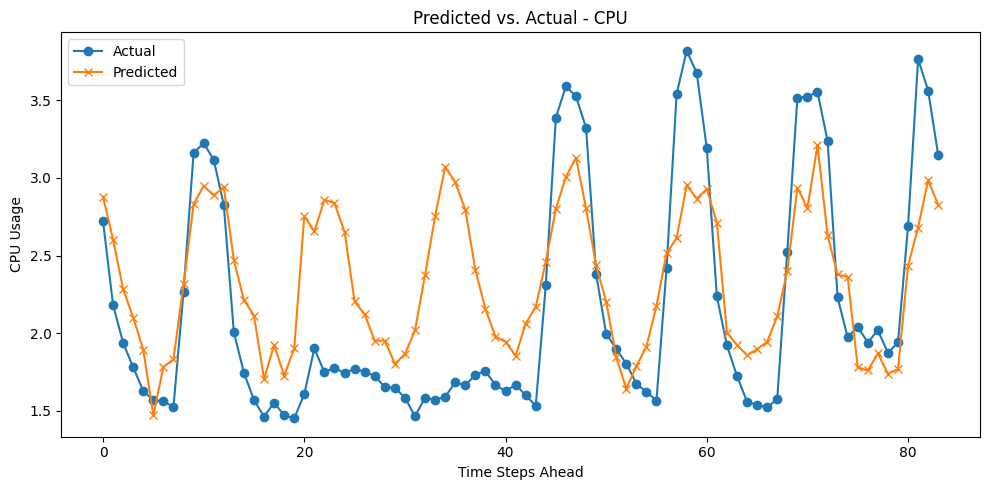

In [84]:
NUM_FEATURES = 1
dfs_M, scaler = load_dfs("../data/processed/cpu_features_standardized_M")
model, X_train, y_train = train_on_dfs()
test_on_dfs(model)

Final Training Shape: (1338, 84, 1) (1338, 84, 1)
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 84, 1)]           0         
                                                                 
 masking_7 (Masking)         (None, 84, 1)             0         
                                                                 
 conv1d_7 (Conv1D)           (None, 84, 128)           1664      
                                                                 
 batch_normalization_7 (Batc  (None, 84, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dense_14 (Dense)            (None, 256)               33024     
         

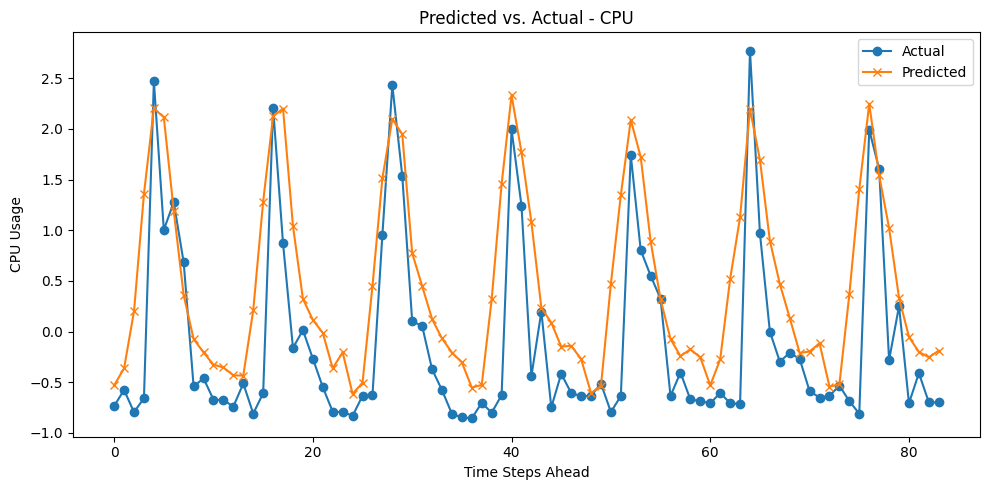

In [85]:
NUM_FEATURES = 1
dfs_M, scaler = load_dfs("../data/processed/network_features_standardized_M")
model, X_train, y_train = train_on_dfs()
test_on_dfs(model)

In [66]:
# Read the CSV file with timestamp parsing
test_df = pd.read_csv(f'{PROCESSED_AZURE_DATA_PATH}azure.csv', parse_dates=['timestamp'])

# Clean column names
test_df.columns = test_df.columns.str.strip().str.replace(' ', '_')

# Set the timestamp as the index
test_df.set_index('timestamp', inplace=True)

# Resample the data to 2-hour intervals (using mean aggregation)
test_df_resampled = test_df.resample('2H').max().dropna()

# Define required features and add missing ones as zeros
required_features = ["max_cpu", "MEMORY_USAGE_KB", "AVG_DISK_IO_RATE_KBPS", "AVG_NETWORK_TR_KBPS"]
test_df_resampled = test_df_resampled.reindex(columns=required_features, fill_value=0)  # Fill missing with 0

# Rename avg_cpu to match the model's input CPU_USAGE_MHZ
test_df_resampled.rename(columns={"max_cpu": "CPU_USAGE_MHZ"}, inplace=True)

In [67]:
test_df_resampled

,CPU_USAGE_MHZ,MEMORY_USAGE_KB,AVG_DISK_IO_RATE_KBPS,AVG_NETWORK_TR_KBPS
timestamp,,,,
2017-01-01 00:00:00,2.284282e+06,0,0,0
2017-01-01 02:00:00,2.152494e+06,0,0,0
2017-01-01 04:00:00,2.146585e+06,0,0,0
2017-01-01 06:00:00,2.183444e+06,0,0,0
2017-01-01 08:00:00,2.181226e+06,0,0,0
...,...,...,...,...
2017-01-30 14:00:00,2.541328e+06,0,0,0
2017-01-30 16:00:00,2.617271e+06,0,0,0
2017-01-30 18:00:00,2.559966e+06,0,0,0


In [68]:
# divide data by 100 to normalize
test_df_resampled = test_df_resampled / 100

In [69]:
# Normalize test data using MinMaxScaler
test_scaled = scaler.transform(test_df_resampled)

# Convert to DataFrame to keep column names
test_scaled_df = pd.DataFrame(test_scaled, index=test_df_resampled.index, columns=test_df_resampled.columns)
test_scaled_df

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- MEMORY_USAGE_KB


In [30]:
# Save test data to file as pandas
test_scaled_df.to_parquet(f'{PROCESSED_AZURE_DATA_PATH}azure.parquet')

7/7 [==============================] - 0s 30ms/step


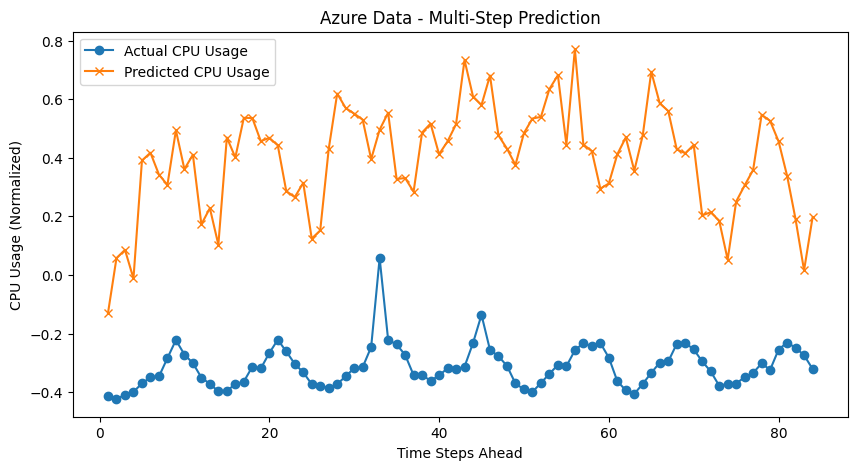

In [31]:
# Generate sequences for testing
X_test, y_test = create_multi_feature_sequences(test_scaled_df, SEQ_LENGTH, FORECAST_HORIZON)

# Make predictions
y_pred_scaled = model.predict(X_test)

# Extract only the last sequence's prediction for comparison
y_pred_last = y_pred_scaled[-1, :, 0]  # Last test sequence's predicted CPU values

# Extract actual CPU values for the last forecast horizon steps
y_actual = y_test[-1, :, 0]  # Last test sequence's actual CPU values

# Plot predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(range(1, FORECAST_HORIZON + 1), y_actual, label="Actual CPU Usage", marker="o")
plt.plot(range(1, FORECAST_HORIZON + 1), y_pred_last, label="Predicted CPU Usage", marker="x")
plt.xlabel("Time Steps Ahead")
plt.ylabel("CPU Usage (Normalized)")
plt.title("Azure Data - Multi-Step Prediction")
plt.legend()
plt.show()